# How do errors propagate through the pseudobatch transformation?

In [1]:
import logging
import os

from functools import partial
from pprint import pprint


import arviz as az
import cmdstanpy
import numpy as np
import pandas as pd
from tqdm import tqdm


from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from scipy.special import logit

os.chdir("..")

from src.util import get_lognormal_parameters_from_quantiles, get_normal_parameters_from_quantiles
from src.data_correction import pseudobatch_transform

# Don't print cmdstanpy warnings
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

os.getcwd()

'/Users/tedgro/Code/fedbatch-data-correction'

# Load data

This cell loads some data.

In [2]:
FEDBATCH_FILE = os.path.join("simulated_data", "standard_fed-batch_process.csv")
SPECIES = ["Product", "Glucose", "Biomass"]

def decumulate(s: pd.Series) -> pd.Series:
    """Get components from a cumulative sum, assuming the first entry is zero."""
    return (s - s.shift(1)).fillna(0)

samples = (
    pd.read_csv(FEDBATCH_FILE, index_col=0)
    .dropna(subset=["sample_volume"])
    .drop_duplicates(subset=["timestamp"], keep="first")
    .assign(
        v_feed_interval=lambda df: decumulate(df["v_Feed_accum"]),
        
    )
    .reset_index()
)

for species in SPECIES:
    samples[f"c_{species}_pseudo"] = pseudobatch_transform(
            measured_concentration=samples["c_" + species].values,
            reactor_volume=samples["v_Volume"].values,
            accumulated_feed=samples["v_Feed_accum"].values,
            concentration_in_feed=0,
            sample_volume=samples["sample_volume"].values,
        )
samples[
    ["timestamp", "v_Volume", "v_Feed_accum", 
     "m_Product", "m_Glucose", "m_Biomass", 
     "c_Product", "c_Glucose", "c_Biomass",
     "c_Product_pseudo", "c_Glucose_pseudo", "c_Biomass_pseudo"]
].round(2)

,timestamp,v_Volume,v_Feed_accum,m_Product,m_Glucose,m_Biomass,c_Product,c_Glucose,c_Biomass,c_Product_pseudo,c_Glucose_pseudo,c_Biomass_pseudo
0,10.00,1015.91,15.91,705.79,76.21,1359.13,0.69,0.08,1.34,0.69,0.08,1.34
1,14.55,928.96,28.96,1215.59,69.68,1930.49,1.31,0.08,2.08,1.33,0.08,2.11
2,19.09,847.31,47.31,1899.09,63.64,2713.96,2.24,0.08,3.20,2.32,0.08,3.32
3,23.64,772.82,72.82,2806.60,57.98,3771.17,3.63,0.08,4.88,3.89,0.08,5.23
4,28.18,707.80,107.80,3995.53,53.13,5172.52,5.65,0.08,7.31,6.37,0.08,8.24
5,32.73,655.12,155.12,5530.85,49.14,6997.77,8.44,0.08,10.68,10.26,0.09,12.99
6,37.27,618.29,218.29,7489.78,46.38,9341.84,12.11,0.08,15.11,16.40,0.10,20.46
7,41.82,601.72,301.72,9980.43,45.16,12337.28,16.59,0.08,20.50,26.07,0.12,32.23
8,46.36,611.32,411.32,13184.88,45.88,16206.65,21.57,0.08,26.51,41.31,0.14,50.78
9,50.91,655.74,555.74,17436.39,49.21,21356.19,26.59,0.08,32.57,65.31,0.18,80.00


The statistical model assumes that our measurements of container volume $y_v$, species concentration $y_c$, feed volume $y_f$, sample volume $y_s$ and feed concentration $y_{cfeed}$ have log-normal probability distributions that depend on the true values $v$, $c$, $f$, $s$ and $cfeed$ as well as known quantities $\sigma_v$, $\sigma_c$, $\sigma_f$, $\sigma_s$ and $\sigma_{cfeed}$ as follows:

\begin{align*}
y_v &\sim LN(\ln{v}, \sigma_v) \\
y_c &\sim LN(\ln{c}, \sigma_c) \\
y_f &\sim LN(\ln{f + \alpha_{pump}}, \sigma_f) \\
y_s &\sim LN(\ln{s}, \sigma_s) \\
y_s &\sim LN(\ln{s}, \sigma_s) \\
y_{cfeed}
\end{align*}

The known values are stored in a Python dictionary:

In [3]:
KNOWN_QUANTITIES = {
    "sigma_v": 0.05,
    "sigma_c": [0.05] * 3,
    "sigma_f": 0.05,
    "sigma_s": 0.05,
    "sigma_cfeed": 0.05,
}

The model also has unknown quantities. These are:

* $v_0$: the volume of the container at the start of the experiment.
* $m$: a vector of per-sample species masses.
* $\alpha_s$: a vector of per-sample volumes, expressed as logit-scale fractions of the pre-sample volume.
* $f_{\text{non-zero}}$: a vector containing the feed volume for each pre-sample interval where feeding took place.
* $cfeed_{\text{non-zero}}$: the concentration of feed in the feed solution, if there is any.
* $\alpha_{pump}$: the factor according to which measurements of feed volume are biased, on $\ln$ scale

The next cell shows the priors we chose for these unknowns, for the purposes of this analysis.

Note that some quantities are assumed to be known quite precisely, such as $\alpha_{pump}$ and $cfeed_{\text{non-zero}}$, whereas others like $\alpha_s$ and $v_0$ have a wider range and some unknowns like $m$ have very wide ranges of plausible values.

In [4]:
get_99_pct_lognormal = partial(get_lognormal_parameters_from_quantiles, p1=0.005, p2=0.995)
get_99_pct_normal = partial(get_normal_parameters_from_quantiles, p1=0.005, p2=0.995)
get_99_pct_normal_ctr = partial(get_normal_parameters_from_quantiles, p1=0.005, p2=0.5)


PRIORS = {
    "prior_alpha_pump":    list(get_99_pct_normal_ctr(x1=np.log(1-0.1), x2=0)), # probably better than +/- 10% accurate
    "prior_alpha_s":       list(get_99_pct_normal(x1=logit(0.05), x2=logit(0.4))),
    "prior_v0":            list(get_99_pct_lognormal(x1=1000, x2=1030)),
    "prior_m":             [
        list(get_99_pct_lognormal(x1=200, x2=200000)),  # product
        list(get_99_pct_lognormal(x1=2, x2=2000)),      # glucose
        list(get_99_pct_lognormal(x1=200, x2=200000)),  # biomass
                           ],
    "prior_f_nonzero":     list(get_99_pct_lognormal(x1=10, x2=1000)),
    "prior_cfeed_nonzero": list(get_99_pct_lognormal(x1=0.01, x2=0.1))
}
{k: list(map(lambda x: np.round(x, 2), v)) for k, v in PRIORS.items()}

{'prior_alpha_pump': [0.0, 0.04],
 'prior_alpha_s': [-1.67, 0.49],
 'prior_v0': [6.92, 0.01],
 'prior_m': [array([8.75, 1.34]), array([4.15, 1.34]), array([8.75, 1.34])],
 'prior_f_nonzero': [4.61, 0.89],
 'prior_cfeed_nonzero': [-3.45, 0.45]}

# Load Stan model

This cell compiles the Stan program representing our statistical model and loads it as a cmdstanpy `CmdStanModel` object.

In [5]:
model = cmdstanpy.CmdStanModel(stan_file="src/stan/error_propagation.stan")

In [6]:
stan_input_base = PRIORS | KNOWN_QUANTITIES | {
        "N": len(samples),
        "S": len(SPECIES),
        "y_v": samples["v_Volume"].values.tolist(),
        "y_f": samples["v_feed_interval"].values.tolist(),
        "y_c": samples[["c_" + s for s in SPECIES]].values.tolist(),
        "y_s": samples["sample_volume"].values.tolist(),
        "y_cfeed": 0,
        "t": samples["timestamp"].values.tolist(),
}
    

pprint(
    {
        k: list(map(lambda x: np.round(x, 2), v)) 
        if isinstance(v, list) 
        else v 
        for k, v in stan_input_base.items()
    }, 
    compact=True,
    width=120
)
                    

{'N': 12,
 'S': 3,
 'prior_alpha_pump': [0.0, 0.04],
 'prior_alpha_s': [-1.67, 0.49],
 'prior_cfeed_nonzero': [-3.45, 0.45],
 'prior_f_nonzero': [4.61, 0.89],
 'prior_m': [array([8.75, 1.34]), array([4.15, 1.34]), array([8.75, 1.34])],
 'prior_v0': [6.92, 0.01],
 'sigma_c': [0.05, 0.05, 0.05],
 'sigma_cfeed': 0.05,
 'sigma_f': 0.05,
 'sigma_s': 0.05,
 'sigma_v': 0.05,
 't': [10.0, 14.55, 19.09, 23.64, 28.18, 32.73, 37.27, 41.82, 46.36, 50.91, 55.45, 60.0],
 'y_c': [array([0.69, 0.08, 1.34]), array([1.31, 0.08, 2.08]), array([2.24, 0.08, 3.2 ]), array([3.63, 0.08, 4.88]),
         array([5.65, 0.08, 7.31]), array([ 8.44,  0.08, 10.68]), array([12.11,  0.08, 15.11]),
         array([16.59,  0.08, 20.5 ]), array([21.57,  0.08, 26.51]), array([26.59,  0.08, 32.57]),
         array([31.17,  0.08, 38.09]), array([34.98,  0.08, 42.69])],
 'y_cfeed': 0,
 'y_f': [0.0, 13.05, 18.35, 25.5, 34.98, 47.32, 63.17, 83.43, 109.6, 144.42, 192.83, 263.21],
 'y_s': [100.0, 100.0, 100.0, 100.0, 100.0, 100.

Run Stan and check diagnostics

In [7]:
mcmc_prior = model.sample(data=stan_input_base | {"likelihood": 0})
mcmc_posterior = model.sample(data=stan_input_base | {"likelihood": 1})
print(mcmc_prior.diagnose())
print(mcmc_posterior.diagnose())

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Processing csv files: /var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/tmpc7xtbm_c/error_propagationo0zy13sy/error_propagation-20230302142709_1.csv, /var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/tmpc7xtbm_c/error_propagationo0zy13sy/error_propagation-20230302142709_2.csv, /var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/tmpc7xtbm_c/error_propagationo0zy13sy/error_propagation-20230302142709_3.csv, /var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/tmpc7xtbm_c/error_propagationo0zy13sy/error_propagation-20230302142709_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent trans

In [8]:
mcmc_posterior.summary().sort_values("R_hat")

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
"c[12,3]",42.65050,0.028844,2.158480,39.19930,42.59920,46.30310,5600.00,9380.23,0.999129
"m[12,3]",38680.10000,29.109200,2108.290000,35366.70000,38638.60000,42272.90000,5245.64,8786.67,0.999130
s[10],100.32700,0.068406,5.014260,92.25980,100.15400,108.76400,5373.14,9000.24,0.999147
f_nonzero[6],63.33620,0.039623,3.158760,58.39300,63.18110,68.68070,6355.21,10645.20,0.999158
f[7],63.33620,0.039623,3.158760,58.39300,63.18110,68.68070,6355.21,10645.20,0.999158
...,...,...,...,...,...,...,...,...,...
alpha_s[9],-1.62882,0.000869,0.061475,-1.72959,-1.62782,-1.52884,5001.28,8377.35,1.001480
v[7],616.30700,0.170530,9.732470,600.24100,616.42800,632.45100,3257.19,5455.93,1.001480
v[8],599.67100,0.184524,10.482700,582.68500,599.54800,616.91000,3227.32,5405.89,1.001640
f[1],0.00000,NaN,0.000000,0.00000,0.00000,0.00000,NaN,NaN,NaN


Convert results to arviz `InferenceData`.

In [10]:
coords = {"sample": samples.index, "species": SPECIES}
dims = {
    "s": ["sample"],
    "f": ["sample"],
    "c": ["sample", "species"],
    "v": ["sample"],
    "pseudobatch_c": ["sample", "species"]
}
idata_prior, idata_posterior = (
    az.from_cmdstanpy(mcmc, coords=coords, dims=dims) for mcmc in [mcmc_prior, mcmc_posterior]
)
idata_posterior

Inference data with groups:
	> posterior
	> sample_stats

Plot interesting quantities

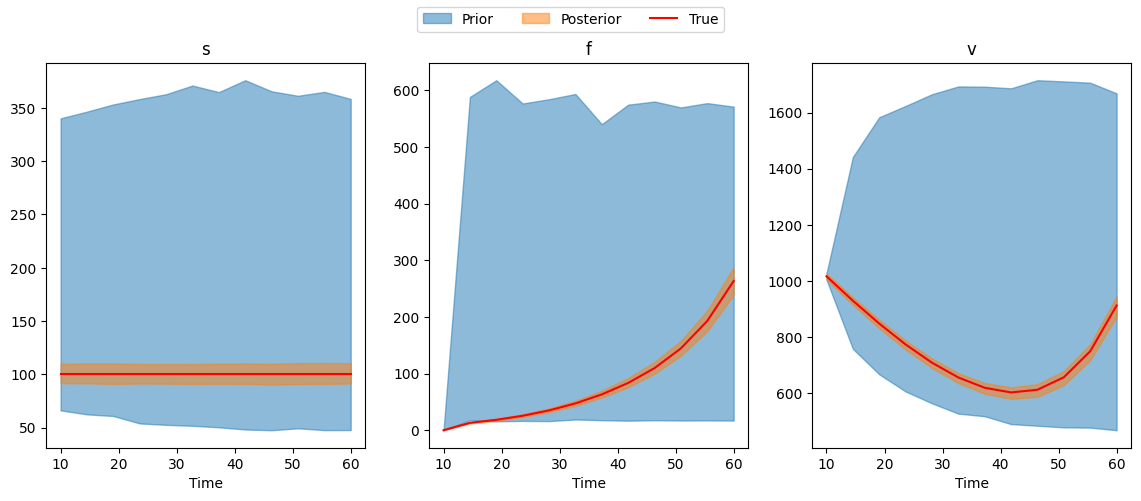

In [11]:
def plot_timecourse_qs(
    ax: plt.Axes,
    varname: str, 
    idata: az.InferenceData, 
    timepoints: pd.Series,
    coords: dict,
    quantiles: list = [0.025, 0.975],
    **fill_between_kwargs
) -> PolyCollection:
    var_draws = idata.posterior[varname]
    for k, v in coords.items():
        if k in var_draws.coords:
            var_draws = var_draws.sel({k:v})
    qs = var_draws.quantile(quantiles, dim=["chain", "draw"]).to_dataframe()[varname].unstack("quantile")
    low = qs[0.025].values
    high = qs[0.975].values
    x = timepoints.values
    return ax.fill_between(x, low, high, **fill_between_kwargs)


f, axes = plt.subplots(1, 3, figsize=[14, 5])
for ax, varname, true_value_colname in zip(
    axes, 
    ["s", "f", "v"], 
    ["sample_volume", "v_feed_interval", "v_Volume"]
):
    pcs = []
    for idata, color in zip([idata_prior, idata_posterior], ["tab:blue", "tab:orange"]):
        pc = plot_timecourse_qs(
            ax,
            varname,
            idata,
            samples["timestamp"],
            {"species": ["Product"]},
            color=color,
            alpha=0.5,
        )
        pcs += [pc]
    line = ax.plot(samples["timestamp"], samples[true_value_colname], color="red")
    txt = ax.set(xlabel="Time", title=varname)
legend = f.legend([*pcs, line[0]], ["Prior", "Posterior", "True"], ncol=3, loc="upper center")

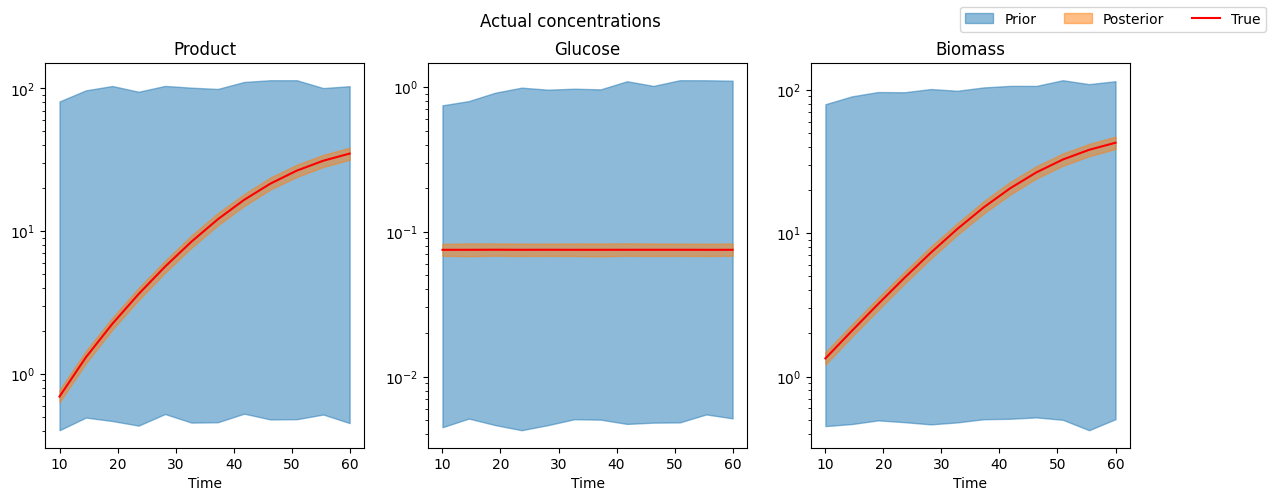

In [16]:
f, axes = plt.subplots(1, 3, figsize=[14, 5])
for ax, species, true_value_colname in zip(
    axes, SPECIES, ["c_" + s for s in SPECIES]
):
    pcs = []
    for idata, color in zip([idata_prior, idata_posterior], ["tab:blue", "tab:orange"]):
        pc = plot_timecourse_qs(
            ax,
            "c",
            idata,
            samples["timestamp"],
            {"species": [species]},
            color=color,
            alpha=0.5,
        )
        pcs += [pc]
    line = ax.plot(samples["timestamp"], samples[true_value_colname], color="red")
    txt = ax.set(xlabel="Time", title=species)
    ax.semilogy()

f.suptitle("Actual concentrations")
legend = f.legend([*pcs, line[0]], ["Prior", "Posterior", "True"], ncol=3, loc="upper right")

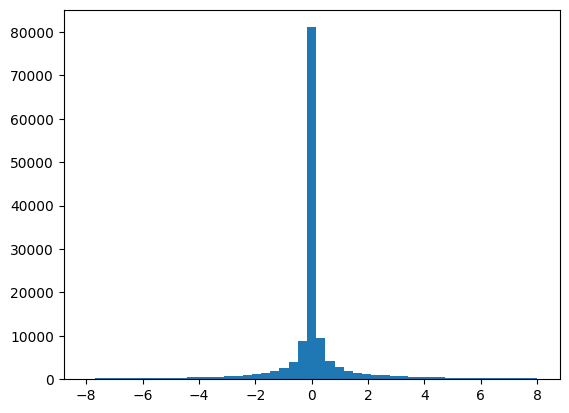

In [17]:
resids = (
    (idata_posterior.posterior["pseudobatch_c"] - samples[["c_Product_pseudo", "c_Glucose_pseudo", "c_Biomass_pseudo"]].values)
    .to_dataframe()
)
resids 

ax = plt.hist(resids.stack().values, bins=np.linspace(-8, 8, 50))

# Compare product measurement error with final product uncertainty

In the next cell we try systematically changing the measurement error for $y_{c}$, then running the model in posterior mode and saving the width of the 99% posterior interval for the last value of $c$ in a dictionary called `widths`.

In [32]:
idata_ensemble = {}
last_sample_width_list = []

for sigma_c in tqdm(np.linspace(0.01, 1, 30)):
    mcmc = model.sample(data=stan_input_base | {"likelihood": 1, "sigma_c": [sigma_c] * 3}, show_progress=False)
    idata_ensemble[sigma_c] = az.from_cmdstanpy(mcmc, coords=coords, dims=dims)
    low, high = idata_ensemble[sigma_c].posterior["pseudobatch_c"].quantile([0.005, 0.995], dim=["chain", "draw"])
    last_sample_width_list.append((high - low).sel(sample=11).values)

last_sample_widths = pd.DataFrame(last_sample_width_list, index=idata_ensemble.keys(), columns=SPECIES)

100%|██████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.78it/s]


Next we plot the hard-coded measurement error values against the posterior interval widths.

Interestingly there is a threshold after which increasing the measurement error stops mattering very much. Probably this is because after this point the measurements are providing very little information compared with the prior.

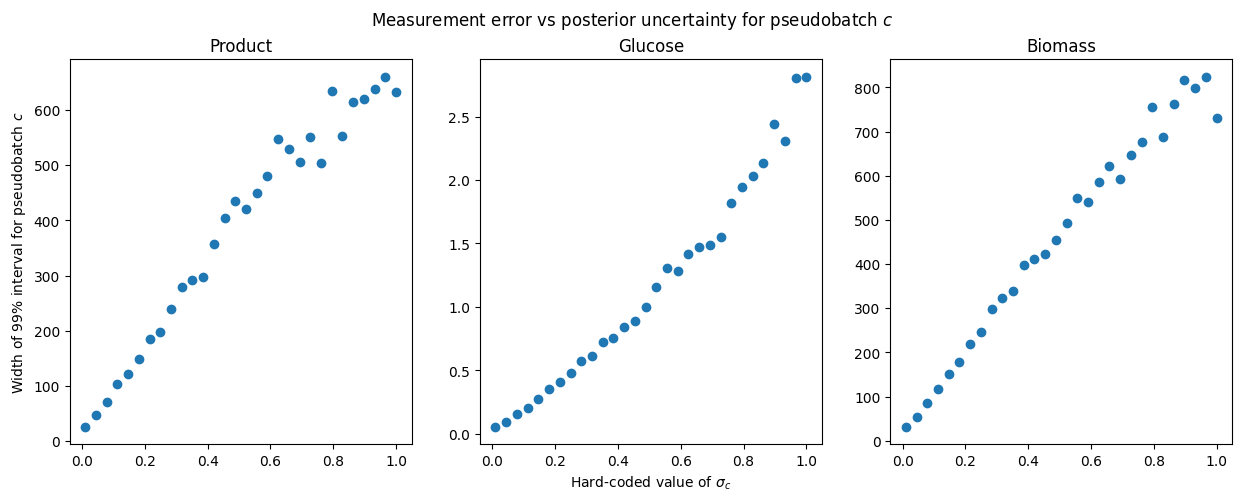

In [33]:
f, axes = plt.subplots(1, 3, figsize=[15, 5])
f.suptitle("Measurement error vs posterior uncertainty for pseudobatch $c$")
for ax, species in zip(axes, SPECIES):
    scatter = ax.scatter(last_sample_widths.index, last_sample_widths[species])
    text = ax.set(title=species)
xlabel = axes[1].set(xlabel="Hard-coded value of $\sigma_c$")
ylabel = axes[0].set(ylabel="Width of 99% interval for pseudobatch $c$")

There appears to be saturating linear relationship between the hardcoded measurement error and the width of the credible interval of the pseudo batch concentration. Thus, we can reject the hypothesis that the uncertainty is severely increased through the pseudo batch transformation. 

In [53]:
relative_width = last_sample_widths / samples[[f"c_{species}_pseudo" for species in SPECIES]].iloc[-1].values

for species in SPECIES:
    lin_coef = np.polyfit(relative_width.index, relative_width[species], deg=1)
    print(f"{species}: {lin_coef}")

Product: [4.0689986  0.31174108]
Glucose: [ 7.71304028 -0.51416022]
Biomass: [4.12053911 0.23773677]


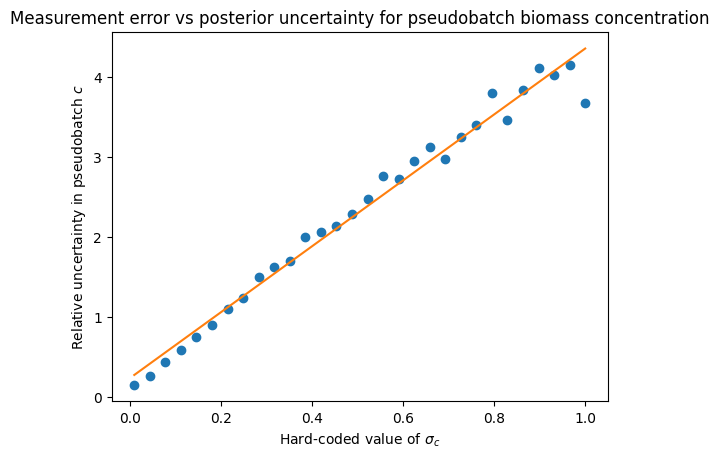

In [66]:
f, ax = plt.subplots()

scatter = ax.scatter(relative_width.index, relative_width["Biomass"])
text = ax.set(
    xlabel="Hard-coded value of $\sigma_c$", 
    ylabel="Relative uncertainty in pseudobatch $c$", 
    title="Measurement error vs posterior uncertainty for pseudobatch biomass concentration"
)
lin_fit = ax.add_line(plt.Line2D(relative_width.index, lin_coef[0] * relative_width.index + lin_coef[1], color="tab:orange"))

During the linear part of data the width of the 99% credible interval increase by 2.9x of the $\sigma_c$. Thus, the relative measurement error does increase through this model. Could this mainly be due to the fact that the posterior some multidimensional space, thus when it is expanded in one dimension the volume increase with quickly?

[]

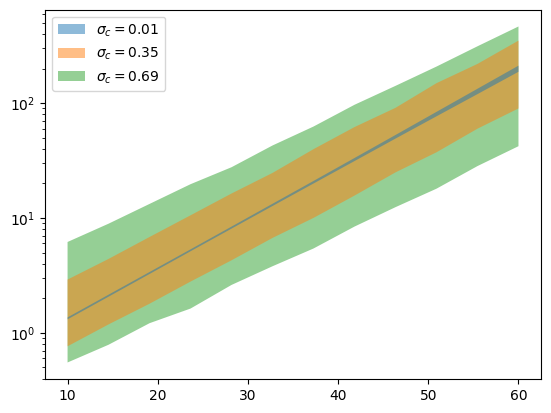

In [68]:
from itertools import islice
f, ax = plt.subplots()
zorder = 1 # just a hack to make to control the order of the layers in the plot
for sigma_c, idata in islice(idata_ensemble.items(), 0, None, 10):
    plot_timecourse_qs(
        ax,
        "pseudobatch_c",
        idata,
        samples['timestamp'],
        coords={"species": ["Biomass"]},
        alpha=0.5,
        label = f"$\sigma_c={sigma_c:.2f}$",
        zorder=zorder
    )
    zorder -=1
ax.legend(loc="upper left")
ax.semilogy()


It actually looks like the 95% credible interval increase quite dramatically towards the end.

In [71]:
# make a function which fits a log-linear model through pandas .apply
def fit_log_linear_model(df):
    x = df.time.values
    y = df.pseudobatch_c.values
    logy = np.log(y)
    slope, intercept = np.polyfit(x, logy, deg=1)
    return pd.Series([slope, intercept], index=['slope', 'intercept'])

fitted_growth_rates = pd.DataFrame()
for sigma_c, idata in islice(idata_ensemble.items(), 0, None, 10):
    # get the posterior of pseudobatch_c
    posterior_df = (idata
        .posterior['pseudobatch_c'].sel(species="Biomass")
        .to_dataframe()
        .reset_index()
    )
    posterior_df['time'] = posterior_df['sample'].map(samples['timestamp'])

    fitted_growth_rates_tmp = (posterior_df
        .groupby(['chain', 'draw'])
        .apply(fit_log_linear_model) 
    )
    # add the sigma_c column
    fitted_growth_rates_tmp['sigma_c'] = sigma_c

    fitted_growth_rates = pd.concat([fitted_growth_rates, fitted_growth_rates_tmp])


0.025    0.070317
0.500    0.098168
0.975    0.106844
Name: slope, dtype: float64


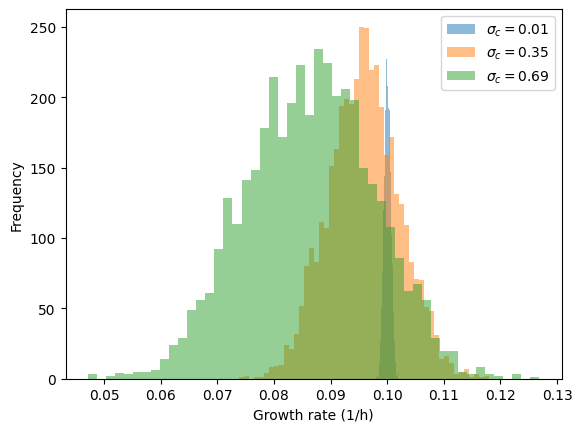

In [72]:
# plot a histogram of the fitted slopes (growth rates)

for sigma_c, group in fitted_growth_rates.groupby('sigma_c'):
    group.slope.plot.hist(bins=50, alpha=0.5, label=f"$\sigma_c={sigma_c:.2f}$")

plt.xlabel('Growth rate (1/h)')
plt.ylabel('Frequency')
plt.legend()

# the 0.025, 0.5 and 0.975 quantiles of the fitted slopes
print(fitted_growth_rates.slope.quantile([0.025, 0.5, 0.975]))

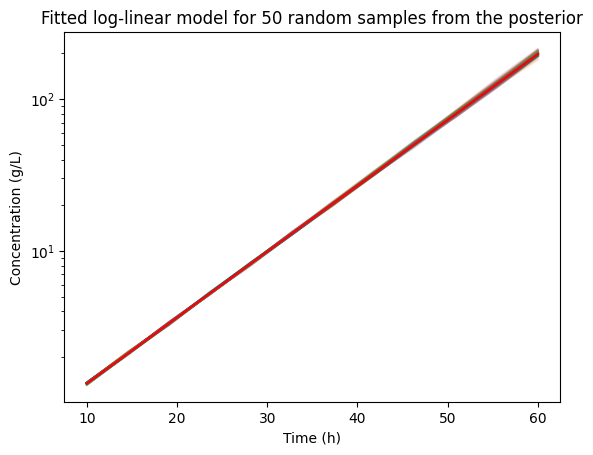

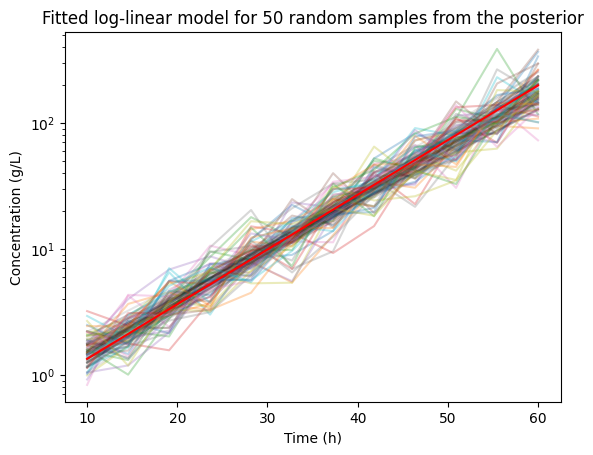

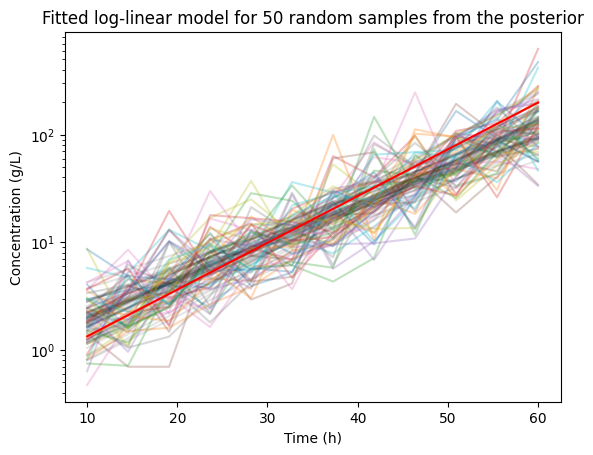

In [73]:
# select 50 random samples from the posterior and plot pseudobatch_c
# and the fitted log-linear model
import matplotlib.colors as mcolors
norm = fitted_growth_rates.sigma_c.unique()
cmap = mcolors.ListedColormap(["C0", "C1", "C2"])
ax_num = 0
for sigma_c, group in fitted_growth_rates.groupby('sigma_c'):
    for (chain, draw), row in group.sample(50, random_state=42).iterrows():
        # plot the posterior samples of pseudobatch_c
        posterior_x = samples['timestamp'].values
        posterior_y = idata_ensemble[sigma_c].posterior.sel(chain=chain, draw=draw, species="Biomass")['pseudobatch_c'].values
        plt.plot(posterior_x, posterior_y, '-', alpha=0.3)

        # plot the fitted log-linear model
        slope, intercept, _ = row
        x = np.linspace(posterior_x.min(), posterior_x.max(), 10)
        y = np.exp(intercept + slope * x)
        plt.plot(x, y, 'k', alpha=0.1)


    plt.plot(samples['timestamp'], samples['c_Biomass_pseudo'], color = 'red')
    plt.semilogy()
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/L)')
    plt.title('Fitted log-linear model for 50 random samples from the posterior')
    plt.show()


In [74]:
fitted_growth_rates.sigma_c.unique()

array([0.01      , 0.35137931, 0.69275862])

In [75]:
expected_sigma_c = 0.2/3 # 99% centain that the value within ±20% of the true value
relative_error_of_pseudobatch_value = (lin_coef[0] * expected_sigma_c + lin_coef[1])/2 # dividing by 2 because the interval is symmetric around the true value
print(f"Relative error of the pseudo-batch value: {relative_error_of_pseudobatch_value:.2%}")

Relative error of the pseudo-batch value: 25.62%


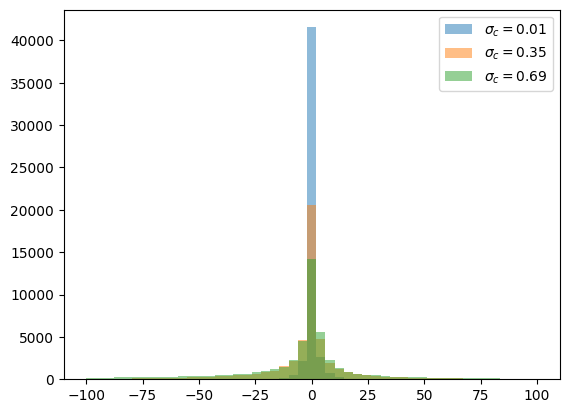

In [78]:

for sigma_c, idata in islice(idata_ensemble.items(), 0, None, 10):
    resid = (
        idata.posterior["pseudobatch_c"].sel(species="Biomass")
        - samples["c_Biomass_pseudo"].values
    ).to_dataframe().unstack("sample")["pseudobatch_c"]
 
    ax = plt.hist(resid.stack().values, bins=np.linspace(-100, 100), alpha=0.5, label=f"$\sigma_c={sigma_c:.2f}$")

plt.legend()

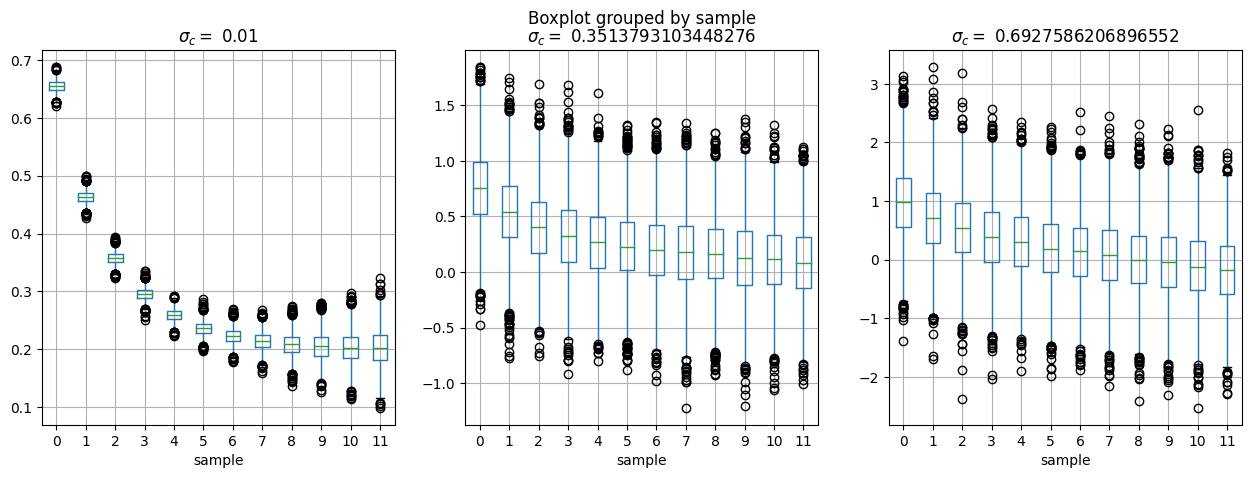

In [80]:
f, axes = plt.subplots(1, 3, figsize=[15, 5])
for ax, (sigma_c, idata) in zip(axes, islice(idata_ensemble.items(), 0, None, 10)):
    log_resid = (
        np.log(idata.posterior["pseudobatch_c"].sel(species="Biomass"))
        - np.log(samples["c_Product_pseudo"].values)
    ).to_dataframe().unstack("sample")["pseudobatch_c"]
    log_resid.stack().reset_index().rename(columns={0:"pseudobatch_c"}).boxplot("pseudobatch_c", by="sample", ax=ax)
    ax.set_title(f"$\sigma_c = $ {sigma_c}")